# Semantic Segmentation (`semseg`)

based on [camvid.ipynb](./camvid.ipynb).

`dataset_object` is ingested through,

```bash
roofAI ingest CamVid <dataset_object>
```

In [1]:
# ! cd ~/git/roofAI; pip3 install -e .

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from abcli import fullname
from abcli import string
from abcli.modules import objects
from abcli.plugins import seed
from roofAI.semseg.augmentation import get_training_augmentation, get_validation_augmentation, get_preprocessing
from roofAI.semseg.dataloader import Dataset
from roofAI.semseg.train import SemSegModelTrainer
from roofAI.semseg.utils import visualize
from roofAI.semseg import Profile
from torch.utils.data import DataLoader
import abcli.logging
import logging

logger = logging.getLogger()

logger.info(f"{fullname()}, built on {string.pretty_date()}")

Found credentials in shared credentials file: ~/.aws/credentials
abcli-7.2362.1-unknown, built on 09 October 2023, 12:01:53


In [3]:
dataset_object = "roofAI-CamVid-v2"
model_object = objects.unique_object("roofAI-CamVid-semseg-model")
profile = Profile.VALIDATION # FULL, QUICK, VALIDATION

📂 roofAI-CamVid-semseg-model-2023-10-09-12-01-53-25971


In [4]:
model_object_path = objects.object_path(object_name=model_object)

In [5]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [6]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [7]:
dataset_path = objects.path_of(
    "SegNet-Tutorial/CamVid/", 
    object_name=dataset_object
)
logger.info(f"dataset_path: {dataset_path}")

dataset_path: /Users/kamangir/storage/abcli/roofAI-CamVid-v2/SegNet-Tutorial/CamVid/


SemSegModelTrainer: /Users/kamangir/storage/abcli/roofAI-CamVid-v2/SegNet-Tutorial/CamVid/ -Profile.VALIDATION-> /Users/kamangir/storage/abcli/roofAI-CamVid-semseg-model-2023-10-09-12-01-53-25971
data review


Dataset: 1 item(s).


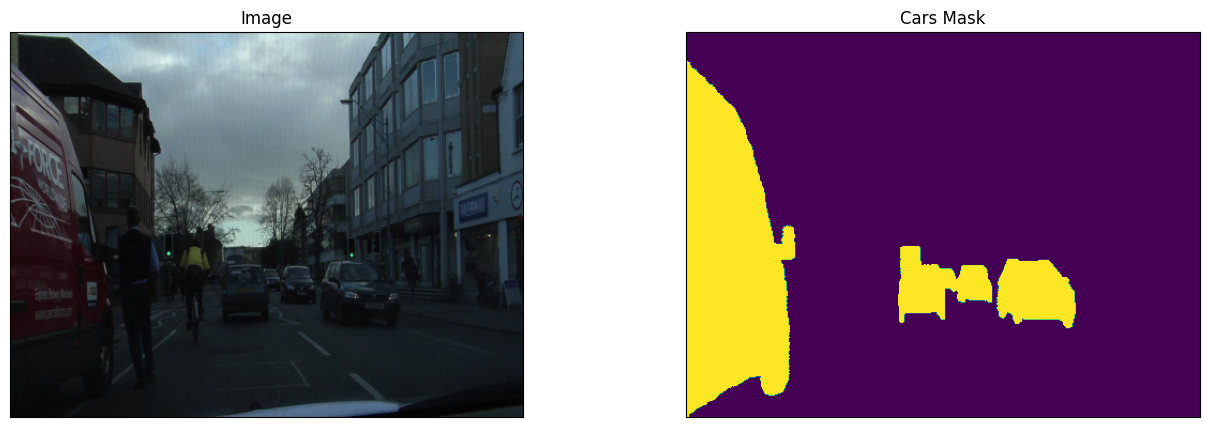

/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/alb

Dataset: 1 item(s).


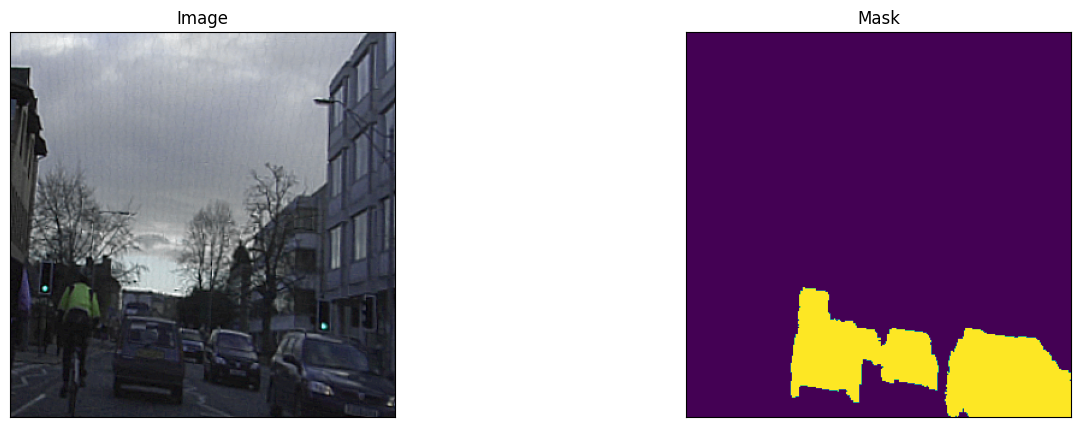

In [8]:
trainer = SemSegModelTrainer(
    dataset_path=dataset_path,
    model_path=model_object_path,
    in_notebook=True,
    profile=profile,
)

## Create model and train

In [9]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu' # 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
train_dataset = Dataset(
    trainer.x_train_dir, 
    trainer.y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    count=profile.data_count
)

valid_dataset = Dataset(
    trainer.x_valid_dir, 
    trainer.y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    count=profile.data_count
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

Dataset: 1 item(s).
Dataset: 1 item(s).


/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.11/site-packages/alb

In [12]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# train model for <epoch_count> epochs

max_score = 0

for i in range(0, profile.epoch_count):
    
    print('epoch: #{}/{}'.format(i+1,profile.epoch_count))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(model_object_path,'best_model.pth'))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

epoch: #1/1
valid: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, dice_loss - 0.9836, iou_score - 0.008114]
Model saved!


## Test best saved model

In [15]:
# load best saved checkpoint
best_model = torch.load(os.path.join(model_object_path, 'best_model.pth'))

In [16]:
# create test dataset
test_dataset = Dataset(
    trainer.x_test_dir, 
    trainer.y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    count=profile.data_count
)

test_dataloader = DataLoader(test_dataset)

Dataset: 1 item(s).


In [17]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, dice_loss - 0.5472, iou_score - 0.2964]


## Visualize predictions

In [18]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    trainer.x_test_dir,
    trainer.y_test_dir, 
    classes=CLASSES,
    count=profile.data_count
)

Dataset: 1 item(s).


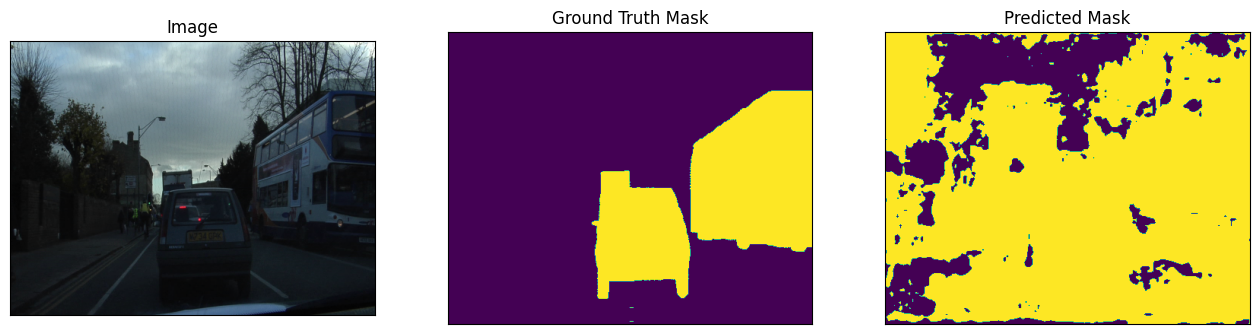

In [19]:
for i in range(1 if profile == Profile.VALIDATION else 5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [20]:
%%bash -s $model_object
source ~/git/awesome-bash-cli/bash/abcli.sh in_notebook

abcli select $1
abcli tag set . built_by_notebook
# abcli upload

📂 abcli: roofAI-CamVid-semseg-model-2023-10-09-12-01-53-25971


roofAI-CamVid-semseg-model-2023-10-09-12-01-53-25971 += #built_by_notebook.


In [21]:
seed.log(
    "download_object",
    object_name=model_object)

abcli select roofAI-CamVid-semseg-model-2023-10-09-12-01-53-25971
abcli download
open .


In [22]:
# END